# Plotting SELTMP data
**Author**: Denisse Fierro Arcos  
  
This notebook will show how to access the RIMReP `geoparquet` collection for the Social and Economic Long-Term Monitoring Program (SELTMP) dataset from CSIRO, which contains the latest results of this survey (2021). This dataset collects data on a subset of Great Barrier Reef (GBR) human dimension indicators relating to social, economic, cultural, and governance aspects of the GBR, as described within the Reef 2050 Long Term Sustainability Plan (Reef 2050 Plan). These human dimensions are considered to play a pivotal role in resilience-based management of the GBR.  
  
In this example, we will produce four figures:  
1. Bar plot showing the proportion of people surveyed performing recreational activities per region
2. Bar plot showing people’s perception of waterway health
3. Bar plot comparing the trust in science by fishers against their perception of climate change
4. Word cloud using the favorite waterways for recreation of the people surveyed

In [148]:
# Accessing S3 bucket
from pyarrow import parquet as pq
# Manipulating dataframes
import pandas as pd
import numpy as np
# Checking patterns in strings using regular expressions (regex)
import re
# Interacting with operating system
import os
# Plotting
import matplotlib.pyplot as plt
# Color maps
from matplotlib import colormaps as cmaps
# Word cloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Connecting to SELTMP dataset in RIMReP collection

In [149]:
#Connecting to metadata file
md = pq.ParquetDataset(f's3://rimrep-data-public/csiro-seltmp-baseline-surveys-jul22/data.parquet')

## Inspecting the structure of the SELTMP dataset

In [150]:
md.schema

REGION: int64
  -- field metadata --
  description: 'REGION (1=WT, 2=TSV, 3=MWI, 4=FIT; 5=GH)'
  new_name: 'REGION (1=WT, 2=TSV, 3=MWI, 4=FIT; 5=GH)'
recruit path: int64
  -- field metadata --
  description: 'Recruiting pathway (1 =  ORU panel, 2 = live link) (added' + 19
  new_name: 'Recruiting PATHWAY (1 = ORU panel, 2 = live link; 3 = email ' + 17
q1: int64
  -- field metadata --
  description: 'Q1 - What is your current residential / home postcode?'
  new_name: 'q1 - home POSTCODE'
q1a: double
  -- field metadata --
  description: 'Q1a - Please select your City / Town (LGA):'
  new_name: 'q1a - city, town or LGA'
q1a-label: string
  -- field metadata --
  description: 'Text value for q1a'
  new_name: 'None'
quotagroup: int64
  -- field metadata --
  description: 'Quota group'
  new_name: 'ORU quota group'
quotagroup-label: string
  -- field metadata --
  description: 'Text value for quotagroup'
  new_name: 'None'
q1b: double
  -- field metadata --
  description: 'Q1b - When in cent

We can see that there are a large number of columns available in this dataset and not all of them can be shown in the table above. We can check the exact number of columns contained in the SELTMP dataset by using the `len` function as shown below.

In [151]:
len(md.schema)

1235

## Loading dataset metadata
We have 1235 columns available, and these columns include a description, and a secondary column name (`new_name`). We will use extra this information and create a new dataframe with it.

In [152]:
# Creating empty lists to store metadata
field = []
description = []
new_name = []

# Looping through each item in the schema
for i in md.schema:
    #Get name of column
    field.append(i.name)
    #If available, get the metadata
    if i.metadata is not None:
        description.append(i.metadata[b'description'].decode('utf-8'))
        new_name.append(i.metadata[b'new_name'].decode('utf-8'))
    #If no metadata, append NaN
    else:
        description.append(np.nan)
        new_name.append(np.nan)

# Creating dataframe from lists
table = pd.DataFrame({'field': field, 'description': description,\
                   'new_name': new_name})

# Checking results
table

,field,description,new_name
0,REGION,"REGION (1=WT, 2=TSV, 3=MWI, 4=FIT; 5=GH)","REGION (1=WT, 2=TSV, 3=MWI, 4=FIT; 5=GH)"
1,recruit path,"Recruiting pathway (1 = ORU panel, 2 = live l...","Recruiting PATHWAY (1 = ORU panel, 2 = live li..."
2,q1,Q1 - What is your current residential / home p...,q1 - home POSTCODE
3,q1a,Q1a - Please select your City / Town (LGA):,"q1a - city, town or LGA"
4,q1a-label,Text value for q1a,None
...,...,...,...
1230,F25,"F25. Prior to completing this survey, were you...","F25 - GLADSTONE - Prior to completing survey, ..."
1231,F25-label,Text value for F25,None
1232,F26,"F26. Prior to completing this survey, were you...","F26 - GLADSTONE - Prior to completing survey, ..."
1233,F26-label,Text value for F26,None


## Extracting data about recreational activities
We can now use our metadata table to find the variables of interest. We will use the `new_name` column to find the variables that contain the words `waterway rec`, which contain information about recreational activities.

In [153]:
#Searching for matches in the new_name column using keywords: 'waterway rec'
rec = table[table['new_name'].str.contains('waterway rec', case=False)]
#Cheking results
rec.head(n = 15)

,field,description,new_name
42,w9_1,W9_1 - Fishing,w9_1 - WET TROPICS ONLY - Waterway Recreation ...
43,w9_2,W9_2 - Boating or sailing,w9_2 - WET TROPICS ONLY - Waterway Recreation ...
44,w9_3,W9_3 - Snorkelling/freediving/Scuba diving,w9_3 - WET TROPICS ONLY - Waterway Recreation ...
45,w9_4,W9_4 - Motor-powered water sports (e.g. water ...,w9_4 - WET TROPICS ONLY - Waterway Recreation ...
46,w9_5,W9_5 - Wind-powered water sports (e.g. kite su...,w9_5 - WET TROPICS ONLY - Waterway Recreation ...
47,w9_6,W9_6 - Paddling/canoeing/kayaking,w9_6 - WET TROPICS ONLY - Waterway Recreation ...
48,w9_7,W9_7 - Camping,w9_7 - WET TROPICS ONLY - Waterway Recreation ...
49,w9_8,W9_8 - Swimming,w9_8 - WET TROPICS ONLY - Waterway Recreation ...
50,w9_9,W9_9 - Picnics and barbeques,w9_9 - WET TROPICS ONLY - Waterway Recreation ...
51,w9_10,W9_10 - Exercising/hiking/biking/running,w9_10 - WET TROPICS ONLY - Waterway Recreation...


From the table above, we can see that question `9` contains data about recreational activities. We can also see that there are multiple options for recreational activities under the same question. We will create a new column that will identify the activity, so we can plot it.

We will also keep the region column (`quotagroup-label`) because this contains the regions where respondents were located and we want to create a bar plot that shows the differences in responses across regions.

In [154]:
#If the field column contains '_other' remove from analysis as this provides
#a description of other recreational activities not named in the survey
rec = rec[~rec.field.str.contains('_other', case = False)].reset_index(drop = True)

#Splitting information in the description column into two columns
#Only keeping the second column (activity) as the first is the same as field
rec = pd.concat([rec, rec.description.str.split(' - ', expand = True)[1]],
                 axis = 1)
#Renaming columns
rec.columns = rec.columns.to_list()[:-1]+['activity']
#Extracting name of region from new_name column (between '-' and 'ONLY')
rec['region'] = rec.apply(lambda x: re.findall('- (.*) ONLY - ', 
                                               x.new_name)[0].title(), 
                           axis=1)

#Checking results
rec.head(n = 15)

,field,description,new_name,activity,region
0,w9_1,W9_1 - Fishing,w9_1 - WET TROPICS ONLY - Waterway Recreation ...,Fishing,Wet Tropics
1,w9_2,W9_2 - Boating or sailing,w9_2 - WET TROPICS ONLY - Waterway Recreation ...,Boating or sailing,Wet Tropics
2,w9_3,W9_3 - Snorkelling/freediving/Scuba diving,w9_3 - WET TROPICS ONLY - Waterway Recreation ...,Snorkelling/freediving/Scuba diving,Wet Tropics
3,w9_4,W9_4 - Motor-powered water sports (e.g. water ...,w9_4 - WET TROPICS ONLY - Waterway Recreation ...,"Motor-powered water sports (e.g. water skiing,...",Wet Tropics
4,w9_5,W9_5 - Wind-powered water sports (e.g. kite su...,w9_5 - WET TROPICS ONLY - Waterway Recreation ...,Wind-powered water sports (e.g. kite surfing),Wet Tropics
5,w9_6,W9_6 - Paddling/canoeing/kayaking,w9_6 - WET TROPICS ONLY - Waterway Recreation ...,Paddling/canoeing/kayaking,Wet Tropics
6,w9_7,W9_7 - Camping,w9_7 - WET TROPICS ONLY - Waterway Recreation ...,Camping,Wet Tropics
7,w9_8,W9_8 - Swimming,w9_8 - WET TROPICS ONLY - Waterway Recreation ...,Swimming,Wet Tropics
8,w9_9,W9_9 - Picnics and barbeques,w9_9 - WET TROPICS ONLY - Waterway Recreation ...,Picnics and barbeques,Wet Tropics
9,w9_10,W9_10 - Exercising/hiking/biking/running,w9_10 - WET TROPICS ONLY - Waterway Recreation...,Exercising/hiking/biking/running,Wet Tropics


Now we have the necessary information to extract the questions from the complete SELTMP dataset that tell us about recreational activities in the study area. We will also need to do some data wrangling to format our data in a way that is easy to plot.

In [34]:
#Using the initial connection to the S3 bucket. Select the columns identified above.
#Read data as pandas dataframe.
recreation  = md.read_pandas(columns = rec.field).to_pandas().reset_index(drop = True)
#We will make the data frame longer. This means that instead of having multiple columns
#for each region/activity, we will have single column containing information about the
#activities/region linked to that observation
recreation['id'] = recreation.index
recreation = pd.melt(recreation, id_vars = 'id', value_vars = recreation.columns[:-1],
                     var_name = 'field', value_name = 'rec_act')
#We remove any rows with no data in the occupation column (i.e., a single respondent 
#cannot be in multiple regions)
recreation.dropna(subset = 'rec_act', inplace = True)
recreation.drop(columns = 'id', inplace = True)
#Join with metadata table
recreation = pd.merge(recreation, rec, on = 'field', how = 'left')
#Correct name of regions
recreation['region'] = recreation.apply(lambda x: x.region.replace('Mwi', 'MWI'), axis = 1)
recreation['region'] = recreation.apply(lambda x: x.region.replace('Glastone', 'Gladstone'), 
                                        axis = 1)
#Removing information in brackets for some categories
recreation['activity'] = recreation['activity'].str.split('(', n = 1, expand = True)[0]

#Summarise data by region and activity
recreation = recreation.groupby(['region', 'activity']).agg({'field': 'size',
                                                'rec_act': 'sum'})
recreation.reset_index(inplace = True)
#We calculate percentage of respondents per activity - No decimals needed
recreation['per_rec'] = np.round((recreation.rec_act/recreation.field)*100, 0)
#Checking result
recreation.head()

,region,activity,field,rec_act,per_rec
0,Fitzroy,Boating or sailing,453,136.0,30.0
1,Fitzroy,Camping,453,147.0,32.0
2,Fitzroy,Exercising/hiking/biking/running,453,188.0,42.0
3,Fitzroy,Fishing,453,225.0,50.0
4,Fitzroy,Motor-powered water sports,453,45.0,10.0


In [156]:
#Calculating mean percentage of respondents per activity to order data in plot
plot_order = recreation.groupby('activity').agg({'per_rec': 'mean'}).reset_index().\
    sort_values('per_rec', ascending = True)
#Checking result
plot_order

,activity,per_rec
11,Wind-powered water sports,1.4
5,Other,7.2
4,Motor-powered water sports,8.4
6,Paddling/canoeing/kayaking,23.0
8,Snorkelling/freediving/Scuba diving,23.8
0,Boating or sailing,31.8
1,Camping,32.8
2,Exercising/hiking/biking/running,49.0
10,Wildlife watching & appreciating nature,49.2
3,Fishing,50.2


## Plotting data about recreational activities
Our data is almost ready to make a plot. We will do some reordering of the data prior to plotting it. We will use the `plot_order` variable to order the data in the plot.

Text(0.5, 0.98, 'Waterway recreation activities performed by respondents')

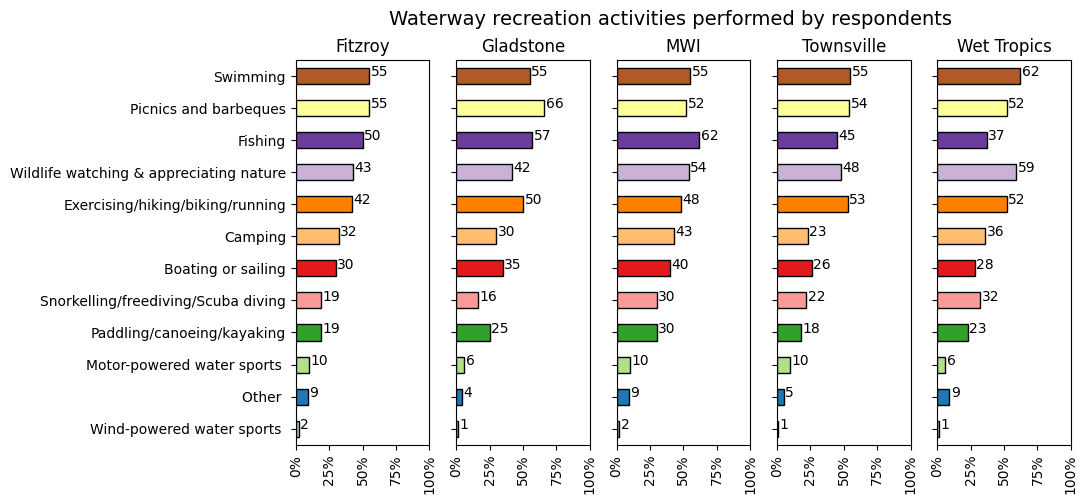

In [157]:
#Grouping data by region and activity
rec_grouped = recreation.pivot(index = 'region', columns = 'activity', values = 'per_rec')
#Ordering activities based on the plot_order dataframe
rec_grouped = rec_grouped[plot_order.activity]

#Start figure
fig = plt.figure(figsize = (10, 5))
#Create as many subplots along one row as there are regions (index of rec_grouped)
#Ensure all subplots share the y axis
axs = fig.subplots(1, len(rec_grouped.index), sharey = True)
#Choosing a colormap for the plot - Separate colours for each activity
cmap = cmaps['Paired'](np.linspace(0, 1, len(rec_grouped.columns)))
#Loop through each region and plot the data
for i, reg in enumerate(rec_grouped.index):
    #Plot as horizontal bar chart
    da = rec_grouped.loc[reg]
    da.plot.barh(ax = axs[i], color = cmap, edgecolor = 'black')
    #Add title to each subplot
    axs[i].set_title(reg)
    #Remove y axis label
    axs[i].set_ylabel('')
    #Set x axis ticks
    axs[i].set_xticks([0, 25, 50, 75, 100])
    axs[i].set_xticklabels(['0%', '25%', '50%', '75%', '100%'], rotation = 90)
    #Adding labels at the end of each bar
    for act, val in enumerate(da.values):
        axs[i].text(val+1.1, act, int(val))

#Add title to figure
fig.suptitle('Waterway recreation activities performed by respondents', fontsize = 14)

This figure shows the proportion of people surveyed that perform recreational activities per region. We can see that the most common recreational activity is swimming, followed by boating and fishing across all regions.  
  
We could save this figure by using the `plt.savefig` function. For example, we could save it as a `png` file by using the following code: `plt.savefig('recreational_activities.png', dpi=300, bbox_inches='tight')`. The `dpi` argument controls the resolution of the figure, and the `bbox_inches` argument controls the size of the bounding box in inches around the figure.

## Extracting data about waterway health
Using the metadata table we loaded towards the beginning of this notebook, we will find the survey questions that cover perceived waterway health.

In [158]:
#Searching for matches in the new_name column using keywords: 'perceived health'
health = table[table['new_name'].str.contains('perceived health', case = False)]
#Cheking results
health.head(n = 15)

,field,description,new_name
106,w13_1,W13_1 - Freshwater creeks and rivers,w13_1 - WET TROPICS Perceived Health FRESH CRE...
108,w13_2,"W13_2 - Freshwater lakes, dams and wetlands",w13_2 - WET TROPICS Perceived Health LAKES DAM...
110,w13_3,W13_3 - Estuaries (including mangroves and sal...,w13_3 - WET TROPICS Perceived Health ESTUARIES...
112,w13_4,W13_4 - Beaches and the coast,w13_4 - WET TROPICS Perceived Health BEACHES &...
114,w13_5,W13_5 - Seagrass,w13_5 - WET TROPICS Perceived Health SEAGRASS ...
116,w13_6,W13_6 - Inshore coral reefs,w13_6 - WET TROPICS Perceived Health INSHORE R...
118,w13_7,W13_7 - Offshore coral reefs,w13_7 - WET TROPICS Perceived Health OFFSHORE ...
120,w13_8,W13_8 - Ocean and sea,w13_8 - WET TROPICS Perceived Health OCEAN & S...
353,t13_1,T13_1 - Freshwater creeks and rivers,t13_1 - TOWNSVILLE Perceived Health FRESH CREE...
355,t13_2,"T13_2 - Freshwater lakes, dams and wetlands",t13_2 - TOWNSVILLE Perceived Health LAKES DAMS...


The first thing we notice is that for some regions there are more questions about perceived health, which refer to areas that are not present across all regions. Since we would like to compare results across regions, we will select areas that are present across all regions. These are covered by questions `13_1` to `13_8`. We will select these from our table of questions above and then use it to load the data we need to create a plot.  
  
We should highlight three issues with the data:  
1. The Fitzroy region does not include information about wetlands (`13_2`) and offshore reefs (`13_7`).  
2. The area categories and ID for the Gladstone region do not match all categories and ID for other regions.  
3. There is no variable dictionary included for the Gladstone region.  
  
Since we do not have information to interpret the Gladstone region (and to maintain things simple), we will ignore this region when creating our plot.  
  
Finally, we will add the `-label` suffix to the `field` column because we would like to access the actual labels of the responses instead of the numerical categories.

In [159]:
#Selecting questions 13_1 to 13_8 and removing questions about the Gladstone region
health = health[(health.field.str.contains('13_[1-8]$')) & ~(health.new_name.str.contains('GLADSTONE'))]
health['field'] = health.apply(lambda x: f'{x.field}-label', axis = 1)
#Extract area being rated from the description column
health = pd.concat([health, health.description.str.split(' - ', expand = True)[1]], axis = 1)
#Renaming columns - so area can be easily identified
health.columns = health.columns.to_list()[:-1]+['area']
#Extracting name of region from new_name column (between '-' and 'Perceived')
health['region'] = health.apply(lambda x: re.findall('- (.+) Perceived', x.new_name)[0], axis = 1)
health.drop(columns = ['description', 'new_name'], inplace = True)
#Resetting row index
health.reset_index(drop = True, inplace = True)
#Checking result
health.head(n = 15)

,field,area,region
0,w13_1-label,Freshwater creeks and rivers,WET TROPICS
1,w13_2-label,"Freshwater lakes, dams and wetlands",WET TROPICS
2,w13_3-label,Estuaries (including mangroves and saltmarshes),WET TROPICS
3,w13_4-label,Beaches and the coast,WET TROPICS
4,w13_5-label,Seagrass,WET TROPICS
5,w13_6-label,Inshore coral reefs,WET TROPICS
6,w13_7-label,Offshore coral reefs,WET TROPICS
7,w13_8-label,Ocean and sea,WET TROPICS
8,t13_1-label,Freshwater creeks and rivers,TOWNSVILLE
9,t13_2-label,"Freshwater lakes, dams and wetlands",TOWNSVILLE


As we did with the previous plot, we will use the table above to extract the questions that contain data about perceptions of waterway health. In this case, we will also need to do some data wrangling to format our data in a way that is easy to plot.

In [160]:
#Using the initial connection to the S3 bucket. Select the columns identified above.
#We will get a list of questions from data frame above and add 'w13_1' to the list to get
#the order of the rating of waterway health
questions = health.field.values.tolist()
questions.append('w13_1')
#Extracting waterway health perception questions
water_health  = md.read_pandas(columns = questions).to_pandas().reset_index(drop = True)

#We will select data for the w13_1 and w13_1-label columns to order health ratings
labels_water = water_health[['w13_1', 'w13_1-label']].drop_duplicates().sort_values('w13_1').\
    dropna().reset_index(drop = True)
#Changing column names to improve readability
labels_water.columns = ['rating', 'label']
#Removing information in brackets for some categories
labels_water['label'] = labels_water['label'].str.split('(', n = 1, expand = True)[0]

#We will make the data frame longer. This means that instead of having multiple columns for each region/area, 
#we will have single column containing information about the region/area linked to 
#that observation
water_health['id'] = water_health.index
water_health = pd.melt(water_health, id_vars = 'id', value_vars = water_health.columns[:-2],
                     var_name = 'field', value_name = 'rating')
#We remove any rows with no data in the occupation column (i.e., a single respondent 
#cannot be in multiple regions)
water_health.dropna(subset = 'rating', inplace = True)
water_health.drop(columns = 'id', inplace = True)
#Join with metadata table
water_health = pd.merge(water_health, health, on = 'field', how = 'left')
#Removing information in brackets for some categories
water_health['rating'] = water_health['rating'].str.split('(', n = 1, expand = True)[0]

#Calculate percentage by rating, so we add rating to the grouping
#Count number of respondents per rating, area and region
water_health = water_health.groupby(['region', 'area', 'rating']).agg({'field': 'size'}).reset_index()
#Calculate total respondents per region
water_health['respondents'] = water_health.groupby(['region', 'area'])['field'].transform('sum')
#We calculate percentage of respondents per activity - No decimals needed
water_health['rate_per'] = np.round((water_health.field/water_health.respondents)*100, 2)
#Checking results
water_health.head()

,region,area,rating,field,respondents,rate_per
0,FITZROY,Beaches and the coast,I don't know,14,467,3.00
1,FITZROY,Beaches and the coast,In fair health,120,467,25.70
2,FITZROY,Beaches and the coast,In good health,302,467,64.67
3,FITZROY,Beaches and the coast,In poor health,20,467,4.28
4,FITZROY,Beaches and the coast,Not applicable,11,467,2.36


## Plotting data about waterway health for the Wet Tropics region
We will show results for a single region as it is difficult to show all regions in a single plot. For this example, we will show the **Wet Tropics**.

Text(0.5, 0.97, 'Rating of perceived waterway health by habitat in the Wet Tropics region')

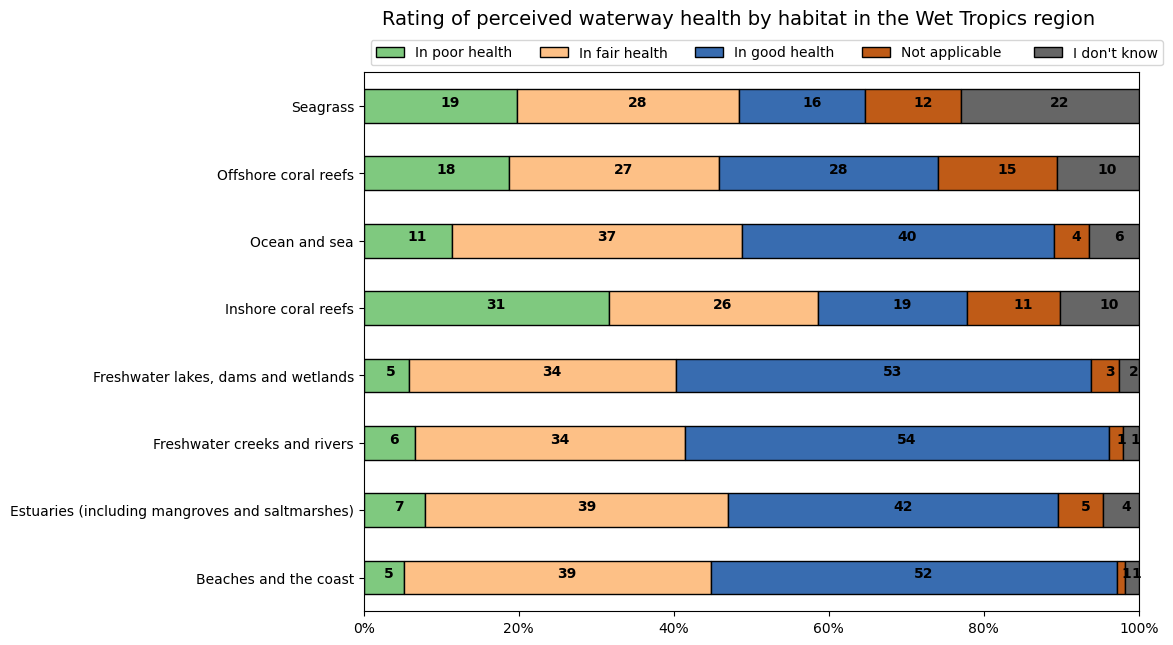

In [170]:
#Selecting Wet Tropics data and reformatting before plotting
water_health_wt = water_health[water_health.region == 'WET TROPICS'].pivot(index = 'area', 
                                                                           columns = 'rating', 
                                                                           values = 'rate_per')
#Ordering activities based on the labels_water dataframe
# water_health_wt = water_health_wt[labels_water.label]
water_health_wt = water_health_wt[labels_water.label]

#Start figure
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111)
#Choosing a colormap for the plot - Separate colours for each activity
cmap = cmaps['Accent'](np.linspace(0, 1, len(water_health_wt.columns)))
#Plot as horizontal bar chart
water_health_wt.plot.barh(stacked = True, ax = ax, color = cmap, edgecolor = 'black', 
                          legend = False)
#Set limits for x axis
ax.set_xlim(0, 100)
#Move legend to the outside of the plot and to the top right of the plot
ax.legend(ncols = len(water_health_wt.columns), bbox_to_anchor = (0, 1), loc = 'lower left')
#Remove y axis label
ax.set_ylabel('')
#Set x axis labels
ax.set_xticks([i for i in range(0, 101, 20)])
ax.set_xticklabels([f'{i}%' for i in range(0, 101, 20)])
#Adding labels in the end of each bar section
for i in range(len(water_health_wt.index)):
    da = water_health_wt.iloc[i].cumsum(axis = 0)
    for j in range(len(da)):
        ax.text(da[j]-(water_health_wt.iloc[i, j]/2), i, int(water_health_wt.iloc[i, j]), fontweight = 'bold') 
#Add title to figure
fig.suptitle('Rating of perceived waterway health by habitat in the Wet Tropics region', y = .97, fontsize = 14)

## Extracting data about governance
Finally, we will replicate one of the plots about governance of waterways that is available in the SELTMP website, which we are including below. By now, you know that the first step is to look for the variables that contain the information we want to plot.

Since the plot does not include a keyword that is common for all variables, we will search for `science` since the first variable in the plot is about “trust in science about waterways”.

![Original plot from SELTMP to be replicated here](../images/sample_plot.jpeg)

In [162]:
#Searching for matches in the description column using keywords: 'science'
table[table['description'].str.contains('science', case = False)]

,field,description,new_name
234,w18_12,W18_12 - I trust the science about waterway he...,w18_12 - WET TROPICS - I TRUST THE SCIENCE abo...
243,w21_5,W21_5 - Science and Education,w21_5 - WET TROPICS - Which Sector of waterway...
489,t18_12,T18_12 - I trust the science about waterway he...,t18_12 - TOWNSVILLE - I TRUST THE SCIENCE abou...
498,t21_5,T21_5 - Science and Education,t21_5 - TOWNSVILLE - Which Sector of waterway ...
737,m18_12,M18_12 - I trust the science about waterway he...,m18_12 - MWI - I TRUST THE SCIENCE about water...
746,m21_5,M21_5 - Science and Education,m21_5 - MWI - Which Sector of waterway depende...
978,f18_12,F18_12 - I trust the science about waterway he...,f18_12 - FITZROY - I TRUST THE SCIENCE about w...
989,f21_5,F21_5 - Science and Education,f21_5 - FITZROY - Which Sector of waterway dep...
1209,F18_12,F18. Please rate your level of agreement with ...,F18_12 - GLADSTONE - I TRUST THE SCIENCE about...
1222,F21_9,F21. Which broad sector of waterway-dependent ...,F21_9 - GLADSTONE - Which Sector of waterway d...


We can see that trust in science falls under question `18`. We will do another query to our table and check that all variables needed for the plot are included in question `18`. We will use additional keywords identifying the questions that are relevant for our plot.

In [38]:
#Keywords representing questions of interest
keys = ['science', 'institutions', 'management', 'access', 'fair', 'influence']
#Selecting questions of interest
govern = table[(table.description.str.contains('|'.join(keys), case = False)) & (table.field.str.contains('18_'))].\
    reset_index(drop = True)
#Cheking results
govern.head()

,field,description,new_name
0,w18_7,W18_7 - I think that decisions about managing ...,w18_7 - WET TROPICS - I think waterway managem...
1,w18_8,W18_8 - I do not have fair access to all the w...,w18_8 - WET TROPICS - I DON'T HAVE FAIR ACCESS...
2,w18_9,W18_9 - I feel I personally have some influenc...,w18_9 - WET TROPICS - I have SOME PERSONAL INF...
3,w18_10,W18_10 - I feel able to have input into the ma...,w18_10 - WET TROPICS - I'm ABLE TO HAVE INPUT ...
4,w18_11,W18_11 - I trust the information I receive fro...,w18_11 - WET TROPICS - I TRUST INFO FROM INSTI...


We have identified the fields containing the information we need to recreate the plot. We now need to tidy up our table as we have done previously.

In [39]:
#Extract region and question being asked from the new_name column
govern = pd.concat([govern, govern.new_name.str.split(' - ', expand = True).iloc[:, 1:3]], axis = 1)
#Renaming columns - so region can be easily identified
govern.columns = govern.columns.to_list()[:-2]+['region', 'question']
#Removing apostrophes from question column before getting question label
govern['question'] = govern['question'].str.replace("'", '')
#Extracting label from question column (everything in capital letters)
govern['question'] = govern.apply(lambda x: re.findall(' [A-Z ]+[A-Z]+', x.question)[0], axis = 1)
#Keep only relevant columns
govern.drop(columns = ['description', 'new_name'], inplace = True)
#Resetting row index
govern.reset_index(drop = True, inplace = True)
#Checking result
govern.head()

,field,region,question
0,w18_7,WET TROPICS,DECISIONS ARE MADE FAIRLY
1,w18_8,WET TROPICS,DONT HAVE FAIR ACCESS
2,w18_9,WET TROPICS,SOME PERSONAL INFLUENCE
3,w18_10,WET TROPICS,ABLE TO HAVE INPUT
4,w18_11,WET TROPICS,TRUST INFO FROM INSTITUTIONS


Note that unlike the previous example, we will not use the `-label` columns because we are interested in the quantifying the level of agreement of the respondents to the statements in the survey.

We will now use the table above to load the questions about governance to our session. As in the previous examples, we will need to do some data wrangling to format our data in a way that is easy to plot.

In [41]:
#Using the initial connection to the S3 bucket. Select the columns identified above.
#Read data as pandas dataframe.
governance = md.read_pandas(columns = govern.field).to_pandas().reset_index(drop = True)
#We will make the data frame longer. This means that instead of having multiple columns
#for each region/question, we will have single column containing information about the region/question 
# linked to that observation
governance['id'] = governance.index
governance = pd.melt(governance, id_vars = 'id', value_vars = governance.columns[:-1],
                     var_name = 'field', value_name = 'agreement')
#We remove any rows with no data in the occupation column (i.e., a single respondent 
#cannot be in multiple regions)
governance.dropna(subset = 'agreement', inplace = True)
#Removing ID because it is not needed
governance.drop(columns = 'id', inplace = True)
#Join with metadata table
governance = pd.merge(governance, govern, on = 'field', how = 'left')
#Correct name of regions
governance['region'] = governance.apply(lambda x: x.region.title() if x.region != 'MWI' else 'MWI', 
                                        axis = 1)
#Summarise data by region and question
governance['respondents'] = governance.groupby(['region', 'question'])['field'].transform('size')
governance['agree_mean'] = governance.groupby(['region', 'question'])['agreement'].transform('mean').round(2)
governance['agree_sd'] = governance.groupby(['region', 'question'])['agreement'].transform('std').round(2)
governance['agree_se'] = governance.agree_sd/np.sqrt(governance.respondents)
#Remove agreement column and drop duplicates
governance.drop(columns = ['agreement', 'field', 'respondents', 'agree_sd'], inplace = True)
governance.drop_duplicates(inplace = True)
governance.reset_index(drop = True, inplace = True)
#Checking results
governance.head()

,region,question,agree_mean,agree_se
0,Wet Tropics,DECISIONS ARE MADE FAIRLY,5.01,0.099530
1,Wet Tropics,DONT HAVE FAIR ACCESS,4.52,0.112919
2,Wet Tropics,SOME PERSONAL INFLUENCE,3.96,0.104439
3,Wet Tropics,ABLE TO HAVE INPUT,4.66,0.105778
4,Wet Tropics,TRUST INFO FROM INSTITUTIONS,5.64,0.116490


In [42]:
#Calculating mean agreement of respondents per question to order data in plot
plot_order = governance.groupby('question').agg({'agree_mean': 'mean'}).reset_index().\
    sort_values('agree_mean', ascending = True)
#Checking result
plot_order

,question,agree_mean
3,SOME PERSONAL INFLUENCE,4.270
2,DONT HAVE FAIR ACCESS,4.410
0,ABLE TO HAVE INPUT,5.004
1,DECISIONS ARE MADE FAIRLY,5.516
4,TRUST INFO FROM INSTITUTIONS,6.016
5,TRUST THE SCIENCE,6.800


## Plotting data about governance
Our data is now ready for us to make a plot. We will order our plot by the mean agreement. Higher agreement will be on the top and decrease towards the bottom.

Text(0.5, 0.98, 'Perceived fairness and trust by respondents in waterway governance')

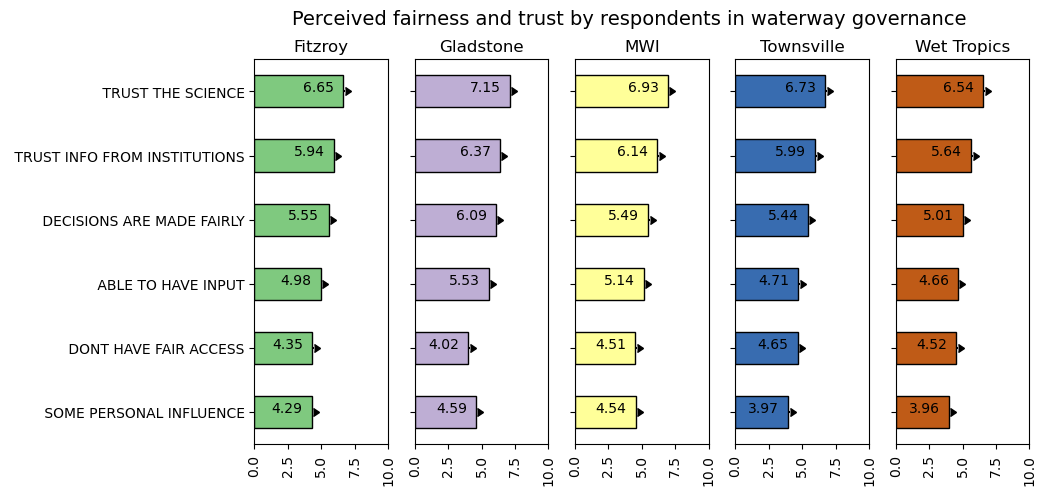

In [43]:
#Grouping data by region and activity
gov_grouped = governance.pivot(index = 'region', columns = 'question', values = ['agree_mean', 'agree_se'])

#Start figure
fig = plt.figure(figsize = (10, 5))
#Create as many subplots along one row as there are regions (index of rec_grouped)
#Ensure all subplots share the y axis
axs = fig.subplots(1, len(gov_grouped.index), sharey = True)
#Choosing a colormap for the plot - Separate colours for each activity
cmap = cmaps['Accent'](np.linspace(0, 1, len(gov_grouped.agree_mean.columns)))
#Loop through each region and plot the data
for i, reg in enumerate(gov_grouped.index):
    #Plot as horizontal bar chart
    means = gov_grouped.loc[reg].agree_mean[plot_order.question]
    se = gov_grouped.loc[reg].agree_se[plot_order.question]
    means.plot.barh(ax = axs[i], color = cmap[i], edgecolor = 'black')
    axs[i].errorbar(means.values, means.index, xerr = se.values, fmt = 'none', color = 'black', xlolims=True)
    #Add title to each subplot
    axs[i].set_title(reg)
    #Remove y axis label
    axs[i].set_ylabel('')
    #Set x axis ticks
    axs[i].set_xticks(np.arange(0, 11, 2.5))
    axs[i].set_xticklabels(np.arange(0, 11, 2.5), rotation = 90)
    #Adding labels at the end of each bar
    for q, val in enumerate(means.values):
        axs[i].text(val-3, q, val)
#Add title to figure
fig.suptitle('Perceived fairness and trust by respondents in waterway governance', fontsize = 14)

## Word cloud example using favourite waterways for recreation
We will search for the relevant questions in our table of variables, and prepare query results to extract data from SELTMP dataset.

In [44]:
#Searching for matches in the new_name column using keywords: 'favourite.*waterway'
water = table[table['description'].str.contains('favourite.*waterway', case = False)].copy()
#Extracting region name from new_name column
water['region'] = water.new_name.str.split(' - ', expand = True)[1].str.replace(' ONLY', '')
#Removing columns not needed
water.drop(columns = ['description', 'new_name'], inplace = True)
#Resetting row index
water.reset_index(drop = True, inplace = True)
#Checking result
water

,field,region
0,w10,WET TROPICS
1,t10,TOWNSVILLE
2,m10,MWI
3,f10,FITZROY


In this case, we will show global results, so we will ignore regions. However, by changing the grouping of the data, we can create wordclouds for each region.

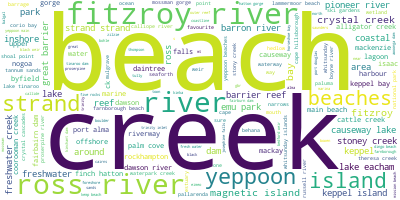

In [45]:
#Extracting favorite waterway questions
fav_water = md.read_pandas(columns = water.field).to_pandas().reset_index(drop = True)

#We will make the data frame longer
fav_water['id'] = fav_water.index
fav_water = pd.melt(fav_water, id_vars = 'id', value_vars = fav_water.columns[:-1],
                     var_name = 'field', value_name = 'waterways')
#We remove any rows with no data in the waterways column (i.e., a single respondent 
#cannot be in multiple regions)
fav_water.dropna(subset = 'waterways', inplace = True)
#Removing ID because it is not needed
fav_water.drop(columns = 'id', inplace = True)
#Cleaning names of waterways before counting
fav_water['waterways'] = fav_water.apply(lambda x: re.sub('\'', '', x.waterways), axis = 1)
#Standardise punctuation before splitting into individual waterways
fav_water['waterways'] = fav_water.apply(lambda x: re.sub('[^\w\s]|  | and | or |the ',
                                                           ';', x.waterways.lower()), axis = 1)
#Splitting waterways into individual rows and count them
fav_water = pd.DataFrame(fav_water.waterways.str.split(';').explode())
#Remove empty rows
fav_water = fav_water[fav_water.waterways != '']
#Get stopwords for wordcloud
stopwords = set(STOPWORDS)
#Add additional stopwords
stopwords.update(['variety', 'havent', 'dont', 'none','not ','no ','wildlife','nil','idk',
                  'lovely','know', '\?','car','fishing','boat','impossible','chair','unsure','secret','swimming'])
#Create a wordcloud
WordCloud(stopwords = stopwords, background_color = 'white').generate(' '.join(fav_water.waterways)).to_image()